In [2]:
import pandas as pd
import os
import pickle
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from conf_ensemble import ConfEnsembleLibrary
from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ccdc_rdkit_connector import CcdcRdkitConnector

In [3]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [4]:
data_dir_path = 'data/'

# Extract PDBBind conformations

In [5]:
pdbbind_refined_dir_path = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir_path = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [9]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(os.path.join(pdbbind_refined_dir_path, 'index', 'INDEX_general_PL_data.2020'), widths=widths, skiprows=6, header=None)
pl_data.columns=cols

In [10]:
pl_data.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG)
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX)
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3)
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP)
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM)


In [11]:
pl_data = pl_data[~pl_data['ligand name'].str.contains('-mer')]

In [12]:
pl_data.shape

(16844, 7)

In [13]:
correct_pdb_ids = pl_data['PDB code'].values
#pdb_ids = sorted([dir for dir in os.listdir(pdbbind_dir) if len(dir) == 4])

In [14]:
def extract_pdbbind_mols(directory_path, query_pdb_ids) :
    mols = []
    pdb_ids = [pdb_id for pdb_id in os.listdir(directory_path) if pdb_id in query_pdb_ids]
    for pdb_id in pdb_ids :
        mol2path = os.path.join(directory_path, pdb_id, f'{pdb_id}_ligand.mol2')
        try :
            mol = Chem.rdmolfiles.MolFromMol2File(mol2path)
            if mol is not None :
                rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
                if rdmol is not None : #rdkit parsable
                    #mol = PropertyMol(mol)
                    mol.GetConformer().SetProp('PDB_ID', pdb_id)
                    mols.append(mol)
                else :
                    print('Not RDKit parsable')
        except :
            print('Impossible to read mol2 file for ' + pdb_id)
            
    return mols

In [15]:
general_mols = extract_pdbbind_mols(pdbbind_general_dir_path, correct_pdb_ids)
print(len(general_mols))

[16:51:39] 6a05_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:39] 6a05_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:39] 1r0x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:39] 1r0x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 1w1g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:40] 1w1g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 2k0g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 1it6_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 4lph_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 6oh3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 3fjz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:40] 6eo0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING

Not RDKit parsable


[16:51:41] 5niy_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:41] 4l2x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 1pyg_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 3dxg_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 4l2x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:41] 4umj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 4umj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:41] 3kc0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 3kc0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 1lqf_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:41] 1lqf_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:41] 4p4j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:41] 4p4j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RD

Not RDKit parsable


[16:51:42] 3wcg_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:42] 2jg8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:42] 2piz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:42] 4yik_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:42] 2o1c_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[16:51:42] 2o1c_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:42] 4du8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:42] 2xy9_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:42] 2wkt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:42] 4p4i_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:42] 2hqu_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:42] 5u51_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:42] 4wz6_lig

Not RDKit parsable


RDKit WARNING: [16:51:46] 1a0q_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:46] 1q6j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:46] 6cus_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:46] 1a0q_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:46] 1ao0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:46] 1q6j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:46] 6cus_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:46] 1ao0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:46] 5z68_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:46] 3mle_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:46] 5z68_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:46] 3mle_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:46] 6c28_ligand: warning - O.co2 wit

Not RDKit parsable


RDKit WARNING: [16:51:47] 3e9i_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:47] 2e9d_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:47] 3e9i_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:47] 5agt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:47] 1yhm_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:47] 5agt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:47] 3fgc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:47] 1me8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:47] 1yhm_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:47] 3fgc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:47] 1me8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:47] 6g02_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:47] 1wvc_ligand: warning - O.co2 wit

10635


RDKit WARNING: [16:51:48] 6a04_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:48] sanitise [16:51:48] 1hyz_ligand: [16:51:48] 5foo_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:48] 2wtx_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:48] 6a04_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.


In [16]:
refined_mols = extract_pdbbind_mols(pdbbind_refined_dir_path, correct_pdb_ids)
print(len(refined_mols))

RDKit WARNING: [16:51:49] 1pdz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:49] 1pdz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:49] 5cks_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:49] 2zz2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:49] 3fzn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:49] 5cks_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:49] 2zz2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:49] 3fzn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:49] 2e94_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:49] 4u6c_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:49] 1ado_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:49] 2e94_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:49] 4u6c_ligand: warning - O.co2 wit

4400


RDKit WARNING: [16:51:52] 6cvf_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 6n9l_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 4g0z_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 5ect_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 5f1x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 5cbm_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit ERROR: [16:51:52] Can't kekulize mol.  Unkekulized atoms: 3 4 19 20 22
RDKit ERROR: 
RDKit WARNING: [16:51:52] sanitise [16:51:52] 4kcx_ligand: [16:51:52] 4uof_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 4g0y_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:51:52] 5uv2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[16:51:52] 6cvf_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [16:5

In [17]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list.p'), 'wb') as f :
    pickle.dump(general_mols, f)

In [18]:
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list.p'), 'wb') as f :
    pickle.dump(refined_mols, f)

In [19]:
general_CEL = ConfEnsembleLibrary(general_mols)
refined_CEL = ConfEnsembleLibrary(refined_mols)

100%|█████████████████████████████████████| 4400/4400 [00:02<00:00, 2001.71it/s]


In [20]:
pdbbind_CEL = general_CEL.merge(refined_CEL)

In [21]:
os.makedirs(os.path.join(data_dir_path, 'raw'), exist_ok=True)

In [22]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(general_CEL, f)

In [23]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_refined_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(refined_CEL, f)

In [24]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(pdbbind_CEL, f)

# Extract Platinum conformations

In [25]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [26]:
len(platinum_mols)

4548

In [27]:
# Add PDB_ID information to conformer
with open(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf')) as f :
    lines = f.readlines()
    lines = [line.strip() for line in lines]

pdb_ids = []
new_mol = True
for line in lines :
    if new_mol :
        pdb_ids.append(line)
        new_mol = False
    if line == '$$$$' :
        new_mol = True
        
for i, mol in enumerate(tqdm(platinum_mols)) :
    mol.GetConformer().SetProp('PDB_ID', pdb_ids[i])

100%|███████████████████████████████████| 4548/4548 [00:00<00:00, 661753.09it/s]


In [28]:
platinum_CEL = ConfEnsembleLibrary(platinum_mols)

100%|█████████████████████████████████████| 4548/4548 [00:01<00:00, 2354.02it/s]


In [29]:
with open(os.path.join(data_dir_path, 'raw', 'platinum_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(platinum_CEL, f)

# Join PDBBind and Platinum, and compare the 2 datasets

In [30]:
all_CEL = pdbbind_CEL.merge(platinum_CEL)

In [31]:
all_CEL.get_num_molecules()

15928

In [32]:
all_smiles = [smiles for smiles, ce in all_CEL.get_unique_molecules()]
pdbbind_smiles = [smiles for smiles, ce in pdbbind_CEL.get_unique_molecules()]
platinum_smiles = [smiles for smiles, ce in platinum_CEL.get_unique_molecules()]

In [33]:
len(pdbbind_smiles)

12344

In [34]:
len(platinum_smiles)

4548

In [35]:
smiles_df = pd.DataFrame(all_smiles, columns=['smiles'])

In [36]:
smiles_df['pdbbind'] = smiles_df['smiles'].isin(pdbbind_smiles)
smiles_df['platinum'] = smiles_df['smiles'].isin(platinum_smiles)

In [37]:
pdbbind_n_heavy_atoms = [ce.mol.GetNumHeavyAtoms() for smiles, ce in pdbbind_CEL.get_unique_molecules()]
platinum_n_heavy_atoms = [ce.mol.GetNumHeavyAtoms() for smiles, ce in platinum_CEL.get_unique_molecules()]

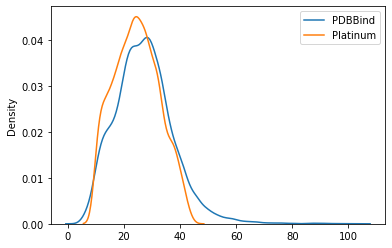

In [38]:
sns.kdeplot(pdbbind_n_heavy_atoms, label='PDBBind')
sns.kdeplot(platinum_n_heavy_atoms, label='Platinum')
plt.legend()
plt.show()

In [39]:
# For computational (conformation generation) and dataset matching reasons,
# PDBBind molecules having more than 50 heavy atoms were excluded

In [40]:
included_smiles = [smiles for smiles, ce in all_CEL.get_unique_molecules() if ce.mol.GetNumHeavyAtoms() <= 50]
smiles_df['included'] = smiles_df['smiles'].isin(included_smiles)

In [41]:
len(included_smiles)

15645

In [42]:
smiles_df.to_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [39]:
ccdc_rdkit_connector = CcdcRdkitConnector()

In [40]:
initial_ccdc_mols = []
corresponding_ce_mols = []
for smiles, conf_ensemble in tqdm(all_CEL.get_unique_molecules()) :
    if smiles in included_smiles : # see comments above
        ccdc_mol = ccdc_rdkit_connector.rdkit_conf_to_ccdc_mol(conf_ensemble.mol)
        assert conf_ensemble.mol.GetNumAtoms() == len(ccdc_mol.atoms)
        initial_ccdc_mols.append(ccdc_mol)
        corresponding_ce_mols.append(conf_ensemble.mol)

100%|███████████████████████████████████| 15928/15928 [00:05<00:00, 3070.29it/s]


In [41]:
n_conf_per_chunk = 100
chunk_idxs = [list(range(i, i + n_conf_per_chunk)) for i in range(0, len(initial_ccdc_mols), n_conf_per_chunk)]

In [42]:
len(initial_ccdc_mols)

15645

In [43]:
ccdc_conformer_generator = ConformerGenerator(nthreads=12)
ccdc_conformer_generator.settings.max_conformers = 100

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


In [44]:
for chunk_idx in tqdm(chunk_idxs) :
    
    mol_list = [mol for i, mol in enumerate(initial_ccdc_mols) if i in chunk_idx]
    ce_mols = [mol for i, mol in enumerate(corresponding_ce_mols) if i in chunk_idx]
    
    conformers = ccdc_conformer_generator.generate(mol_list)
    
    for ce_mol, conformers in zip(ce_mols, conformers) :
        try :
            generated_conf_ids = ccdc_rdkit_connector.ccdc_conformers_to_rdkit_mol(conformers, ce_mol)
        except Exception as e :
            print(e)

  0%|                                                   | 0/157 [00:00<?, ?it/s]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  1%|▎                                        | 1/157 [00:27<1:10:46, 27.22s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  1%|▌                                        | 2/157 [01:29<2:03:37, 47.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  2%|▊                                        | 3/157 [02:04<1:47:15, 41.79s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  3%|█                                        | 4/157 [02:52<1:53:25, 44.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  3%|█▎                                       | 5/157 [03:27<1:43:47, 40.97s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  4%|█▌                                       | 6/157 [04:02<1:37:37, 38.79s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  4%|█▊                                       | 7/157 [04:42<1:38:41, 39.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  5%|██                                       | 8/157 [05:16<1:33:01, 37.46s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  6%|██▎                                      | 9/157 [05:51<1:30:37, 36.74s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  6%|██▌                                     | 10/157 [06:21<1:24:52, 34.65s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  7%|██▊                                     | 11/157 [06:47<1:17:59, 32.05s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  8%|███                                     | 12/157 [07:30<1:25:32, 35.40s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  8%|███▎                                    | 13/157 [08:00<1:21:24, 33.92s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  9%|███▌                                    | 14/157 [08:30<1:17:45, 32.62s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 10%|███▊                                    | 15/157 [08:59<1:14:33, 31.50s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 10%|████                                    | 16/157 [10:34<1:58:40, 50.50s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 11%|████▎                                   | 17/157 [11:10<1:47:40, 46.14s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 11%|████▌                                   | 18/157 [11:42<1:37:41, 42.17s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 12%|████▊                                   | 19/157 [12:11<1:27:27, 38.03s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 13%|█████                                   | 20/157 [13:15<1:44:41, 45.85s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 13%|█████▎                                  | 21/157 [13:43<1:31:53, 40.54s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 14%|█████▌                                  | 22/157 [14:15<1:25:09, 37.85s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 15%|█████▊                                  | 23/157 [15:13<1:38:13, 43.98s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 15%|██████                                  | 24/157 [15:45<1:29:21, 40.31s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 16%|██████▎                                 | 25/157 [16:43<1:40:16, 45.58s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 17%|██████▌                                 | 26/157 [17:59<1:59:35, 54.78s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 17%|██████▉                                 | 27/157 [18:26<1:40:31, 46.39s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 18%|███████▏                                | 28/157 [19:18<1:43:47, 48.27s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 18%|███████▍                                | 29/157 [19:54<1:35:04, 44.56s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 19%|███████▋                                | 30/157 [23:18<3:15:25, 92.33s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 20%|███████▉                                | 31/157 [23:51<2:36:43, 74.63s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 20%|████████▏                               | 32/157 [24:23<2:08:53, 61.87s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 21%|████████▍                               | 33/157 [24:53<1:48:00, 52.27s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 22%|████████▋                               | 34/157 [25:30<1:37:33, 47.59s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 22%|████████▉                               | 35/157 [26:02<1:27:09, 42.87s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 23%|█████████▏                              | 36/157 [26:38<1:22:08, 40.74s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 24%|█████████▍                              | 37/157 [27:10<1:16:27, 38.23s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 24%|█████████▋                              | 38/157 [27:44<1:13:19, 36.97s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 25%|██████████▏                             | 40/157 [29:43<1:38:44, 50.63s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 26%|██████████▍                             | 41/157 [30:15<1:26:35, 44.79s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 27%|██████████▋                             | 42/157 [30:59<1:25:56, 44.84s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 27%|██████████▉                             | 43/157 [31:32<1:17:58, 41.04s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 28%|███████████▏                            | 44/157 [32:03<1:11:40, 38.06s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 29%|███████████▍                            | 45/157 [32:36<1:08:17, 36.58s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 29%|███████████▋                            | 46/157 [33:04<1:03:03, 34.09s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 30%|███████████▉                            | 47/157 [33:40<1:03:15, 34.50s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 31%|████████████▏                           | 48/157 [34:10<1:00:12, 33.14s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 31%|█████████████                             | 49/157 [34:40<58:05, 32.27s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 32%|█████████████▍                            | 50/157 [35:13<57:46, 32.40s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 32%|█████████████▋                            | 51/157 [35:47<58:11, 32.94s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 33%|█████████████▉                            | 52/157 [36:21<58:24, 33.37s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 34%|█████████████▌                          | 53/157 [37:19<1:10:30, 40.68s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 34%|█████████████▊                          | 54/157 [38:06<1:13:05, 42.58s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 35%|██████████████                          | 55/157 [38:38<1:07:12, 39.53s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 36%|██████████████▎                         | 56/157 [39:37<1:16:09, 45.24s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 36%|██████████████▌                         | 57/157 [41:46<1:57:22, 70.43s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 37%|██████████████▊                         | 58/157 [42:17<1:36:37, 58.56s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 38%|███████████████                         | 59/157 [43:14<1:35:08, 58.25s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 38%|███████████████▎                        | 60/157 [44:20<1:37:30, 60.31s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 39%|███████████████▌                        | 61/157 [44:59<1:26:40, 54.17s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 39%|███████████████▊                        | 62/157 [45:44<1:21:24, 51.42s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 40%|████████████████                        | 63/157 [46:16<1:11:11, 45.44s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 41%|████████████████▎                       | 64/157 [46:54<1:06:59, 43.22s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 41%|████████████████▌                       | 65/157 [47:33<1:04:14, 41.89s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 42%|█████████████████▋                        | 66/157 [48:05<59:21, 39.14s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 43%|█████████████████▉                        | 67/157 [48:39<56:18, 37.54s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 43%|█████████████████▎                      | 68/157 [49:37<1:04:35, 43.54s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 44%|██████████████████▍                       | 69/157 [50:10<59:07, 40.31s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 45%|██████████████████▋                       | 70/157 [50:40<54:19, 37.46s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 45%|██████████████████                      | 71/157 [51:33<1:00:00, 41.87s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 46%|███████████████████▎                      | 72/157 [52:04<54:45, 38.65s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 46%|███████████████████▌                      | 73/157 [52:40<53:10, 37.99s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 47%|███████████████████▊                      | 74/157 [53:11<49:34, 35.84s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 48%|███████████████████                     | 75/157 [54:29<1:06:13, 48.46s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 48%|███████████████████▎                    | 76/157 [55:19<1:06:03, 48.93s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 50%|████████████████████▊                     | 78/157 [56:28<54:43, 41.56s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 50%|█████████████████████▏                    | 79/157 [57:17<56:59, 43.84s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 51%|███████████████████▎                  | 80/157 [1:00:23<1:50:52, 86.39s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 52%|███████████████████▌                  | 81/157 [1:00:56<1:28:56, 70.22s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 52%|███████████████████▊                  | 82/157 [1:01:58<1:24:39, 67.73s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 53%|████████████████████                  | 83/157 [1:02:34<1:11:56, 58.33s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 54%|████████████████████▎                 | 84/157 [1:03:09<1:02:35, 51.44s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 54%|█████████████████████▋                  | 85/157 [1:03:44<55:40, 46.40s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 55%|█████████████████████▉                  | 86/157 [1:04:17<50:03, 42.30s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 55%|██████████████████████▏                 | 87/157 [1:05:01<50:00, 42.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 56%|██████████████████████▍                 | 88/157 [1:05:34<46:00, 40.01s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 57%|██████████████████████▋                 | 89/157 [1:06:12<44:27, 39.22s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 57%|██████████████████████▉                 | 90/157 [1:06:46<42:10, 37.78s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 58%|███████████████████████▏                | 91/157 [1:07:25<42:01, 38.21s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 59%|███████████████████████▍                | 92/157 [1:07:56<38:51, 35.87s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 59%|███████████████████████▋                | 93/157 [1:08:25<36:11, 33.94s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 60%|███████████████████████▉                | 94/157 [1:09:01<36:12, 34.49s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 61%|████████████████████████▏               | 95/157 [1:09:44<38:19, 37.08s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 61%|████████████████████████▍               | 96/157 [1:10:39<43:14, 42.53s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 62%|████████████████████████▋               | 97/157 [1:11:11<39:18, 39.30s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 62%|████████████████████████▉               | 98/157 [1:11:41<35:48, 36.42s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 63%|█████████████████████████▏              | 99/157 [1:12:13<34:03, 35.23s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 64%|████████████████████████▊              | 100/157 [1:13:45<49:35, 52.20s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 64%|███████████████████████▊             | 101/157 [1:15:47<1:08:22, 73.25s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 65%|█████████████████████████▎             | 102/157 [1:16:25<57:22, 62.59s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 66%|█████████████████████████▌             | 103/157 [1:16:59<48:28, 53.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 66%|█████████████████████████▊             | 104/157 [1:17:27<40:43, 46.11s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 67%|██████████████████████████             | 105/157 [1:17:55<35:23, 40.83s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 68%|██████████████████████████▎            | 106/157 [1:18:28<32:41, 38.45s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 68%|██████████████████████████▌            | 107/157 [1:18:59<30:17, 36.36s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 69%|██████████████████████████▊            | 108/157 [1:19:33<28:58, 35.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 69%|███████████████████████████            | 109/157 [1:20:07<27:58, 34.97s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 70%|███████████████████████████▎           | 110/157 [1:20:33<25:26, 32.48s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 71%|███████████████████████████▌           | 111/157 [1:21:10<25:52, 33.75s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 71%|███████████████████████████▊           | 112/157 [1:23:25<47:59, 63.98s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 72%|████████████████████████████           | 113/157 [1:23:58<40:18, 54.96s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 73%|████████████████████████████▎          | 114/157 [1:24:26<33:26, 46.66s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 73%|████████████████████████████▌          | 115/157 [1:25:02<30:24, 43.43s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 74%|████████████████████████████▊          | 116/157 [1:25:34<27:25, 40.14s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 75%|█████████████████████████████          | 117/157 [1:26:28<29:30, 44.27s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 75%|█████████████████████████████▎         | 118/157 [1:27:06<27:35, 42.45s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 76%|█████████████████████████████▌         | 119/157 [1:27:43<25:44, 40.64s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 76%|█████████████████████████████▊         | 120/157 [1:28:15<23:32, 38.17s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 77%|██████████████████████████████         | 121/157 [1:29:28<29:08, 48.58s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 78%|██████████████████████████████▎        | 122/157 [1:29:59<25:12, 43.20s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 78%|██████████████████████████████▌        | 123/157 [1:30:33<22:55, 40.45s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 80%|███████████████████████████████        | 125/157 [1:31:44<20:12, 37.89s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 80%|███████████████████████████████▎       | 126/157 [1:32:14<18:14, 35.30s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 81%|███████████████████████████████▌       | 127/157 [1:32:48<17:32, 35.09s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 82%|███████████████████████████████▊       | 128/157 [1:33:16<15:53, 32.88s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 82%|████████████████████████████████       | 129/157 [1:33:46<14:57, 32.06s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 83%|████████████████████████████████▎      | 130/157 [1:34:16<14:07, 31.40s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 84%|███████████████████████████████▉      | 132/157 [1:40:05<48:51, 117.26s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 85%|█████████████████████████████████      | 133/157 [1:40:35<36:29, 91.21s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 85%|█████████████████████████████████▎     | 134/157 [1:41:08<28:12, 73.57s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 86%|█████████████████████████████████▌     | 135/157 [1:41:50<23:32, 64.21s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 87%|██████████████████████████████████     | 137/157 [1:42:44<15:06, 45.32s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 89%|██████████████████████████████████▊    | 140/157 [1:43:58<08:54, 31.43s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 90%|███████████████████████████████████    | 141/157 [1:44:27<08:11, 30.69s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 90%|███████████████████████████████████▎   | 142/157 [1:44:56<07:34, 30.28s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 91%|███████████████████████████████████▌   | 143/157 [1:45:22<06:45, 28.95s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 92%|███████████████████████████████████▊   | 144/157 [1:45:50<06:13, 28.74s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 93%|████████████████████████████████████▎  | 146/157 [1:47:25<06:40, 36.40s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 94%|████████████████████████████████████▊  | 148/157 [1:48:25<04:55, 32.80s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 95%|█████████████████████████████████████  | 149/157 [1:48:58<04:23, 32.97s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 96%|█████████████████████████████████████▎ | 150/157 [1:49:26<03:40, 31.43s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 97%|██████████████████████████████████████ | 153/157 [1:50:46<01:52, 28.25s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 99%|██████████████████████████████████████▊| 156/157 [1:52:16<00:29, 29.15s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


100%|███████████████████████████████████████| 157/157 [1:52:29<00:00, 42.99s/it]


In [46]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library_unfiltered.p'), 'wb') as f :
    pickle.dump(all_CEL, f)
    
# here we only have the molecules parsed identically by RDKit (from mol2) and CSD (from smiles)

In [43]:
faulty_smiles = ['O=C[Ru+9]12345(C6=C1C2C3=C64)n1c2ccc(O)cc2c2c3c(c4ccc[n+]5c4c21)C(=O)NC3=O',
 'Cc1cc2c3c(c4c5ccccc5n5c4c2[n+](c1)[Ru+9]51246(Cl)C5=C(C(=O)[O-])C1=C2C4=C56)C(=O)NC3=O']
# cannot be pickled because of a number of radical electron error

In [44]:
smiles_df.loc[smiles_df['smiles'].isin(faulty_smiles), 'included'] = False

In [45]:
smiles_df.to_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [46]:
excluded_smiles = smiles_df[~smiles_df['included']]['smiles'].values

In [47]:
len(excluded_smiles)

285

In [48]:
for smiles in excluded_smiles :
    all_CEL.library.pop(smiles)

In [49]:
all_CEL.get_num_molecules()

15643

In [68]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(all_CEL, f)

# CORRECT : Generator prop in conf

In [1]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    all_CEL = pickle.load(f)

NameError: name 'os' is not defined

In [51]:
included_smiles = smiles_df[smiles_df['included']]['smiles'].values

In [57]:
for smiles in included_smiles :
    n_bio_confs = all_CEL.get_conf_ensemble(smiles).mol.GetNumConformers()
    n_tot_confs = all_CEL2.get_conf_ensemble(smiles).mol.GetNumConformers()
    for conf_id in range(n_bio_confs, n_tot_confs) :
        all_CEL2.get_conf_ensemble(smiles).mol.GetConformer(conf_id).SetProp('Generator', 'CCDC')

In [66]:
for conf in all_CEL.get_conf_ensemble(smiles).mol.GetConformers() :
    print(conf.GetPropsAsDict())

{'PDB_ID': 'ZZZ_2CFI_A'}


In [69]:
for conf in all_CEL2.get_conf_ensemble(smiles).mol.GetConformers() :
    print(conf.GetPropsAsDict())

{'PDB_ID': 'ZZZ_2CFI_A'}
{'PDB_ID': 'ZZZ_2CFI_A', 'Generator': 'CCDC'}
{'PDB_ID': 'ZZZ_2CFI_A', 'Generator': 'CCDC'}
{'PDB_ID': 'ZZZ_2CFI_A', 'Generator': 'CCDC'}
{'PDB_ID': 'ZZZ_2CFI_A', 'Generator': 'CCDC'}
{'PDB_ID': 'ZZZ_2CFI_A', 'Generator': 'CCDC'}
{'PDB_ID': 'ZZZ_2CFI_A', 'Generator': 'CCDC'}


In [67]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(all_CEL2, f)

# Generate conf table for data file creation torch geometric

In [6]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    all_CEL = pickle.load(f)

In [7]:
smiles_df = pd.read_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [11]:
conf_list = []
for smiles in smiles_df[smiles_df['included']]['smiles'].values :
    confs = all_CEL.get_conf_ensemble(smiles).mol.GetConformers()
    for conf in confs :
        generated = 'Generator' in conf.GetPropsAsDict()
        conf_list.append([smiles, generated])

In [12]:
len(conf_list)

1165920

In [13]:
conf_df = pd.DataFrame(conf_list, columns=['smiles', 'generated'])

In [15]:
conf_df.to_csv(os.path.join(data_dir_path, 'conf_df.csv'))